In [1]:
import numpy as np
import uproot
from matplotlib import pyplot as plt

from iminuit import Minuit
from iminuit.cost import poisson_chi2, Template, ExtendedBinnedNLL, LeastSquares
from scipy.stats import norm, truncexpon
from scipy.optimize import root_scalar, minimize

from IPython.display import display
from collections import defaultdict
from joblib import Parallel, delayed

from jacobi import propagate

import mplhep
import pandas
import pickle

In [2]:
def gaussian(x, norm_, mu_, sigma_):
    return (norm_/sigma_)*((1/np.sqrt(2*np.pi)))*np.exp(-((x-mu_)**2)/(2*sigma_**2))

def cost(norm_, mu_, sigma_):
    yg = gaussian(x, norm_, mu_, sigma_)
    res = (y-yg)/np.sqrt(y)
    return np.sum(res**2)

In [3]:
def linear_model(x, par):
    return par[0], par[0]*x+par[1]

def model(x, par):
    return par[0], gaussian(x, par[0], par[1], par[2])

In [4]:
def line(x, a, b):
    return b + x * a

In [5]:
def mc_linear(m_, c_):
    yg = m_*(x**2)+c_
    res = (y**2-yg)/mc_err
    return np.sum(res**2)

def data_linear(m_, c_):
    yg = m_*(x**2)+c_
    res = (y**2-yg)/data_err
    return np.sum(res**2)

def mc_linear_drn(m_, c_):
    yg = m_*(x**2)+c_
    res = (y**2-yg)/mc_drn_err
    return np.sum(res**2)

def data_linear_drn(m_, c_):
    yg = m_*(x**2)+c_
    res = (y**2-yg)/data_drn_err
    return np.sum(res**2)

def mc_linear_dnn(m_, c_):
    yg = m_*(x**2)+c_
    res = (y**2-yg)/mc_dnn_err
    return np.sum(res**2)

def data_linear_dnn(m_, c_):
    yg = m_*(x**2)+c_
    res = (y**2-yg)/data_dnn_err
    return np.sum(res**2)

In [6]:
# set custom functions
plt.rcParams['axes.linewidth'] = 1.4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'

In [7]:
def fit_imu(ax, x, y):
    ye = np.sqrt(y)
    ye = ye[ye>0]
    m = Minuit(cost, norm_=np.sqrt(max(y)*sum(y)), mu_=np.average(x, weights=y), sigma_=1.0)
    m.migrad()
    print(m.params)
    yf, ycov = propagate(lambda p: model(x, p)[1], m.values, m.covariance)
    yerr_prop = np.diag(ycov) ** 0.5

    # plot everything
    ax.errorbar(x, y, ye, fmt="o", label="data", zorder=0)
    ax.plot(x, yf, lw=3, label="fit")
    # draw 1 sigma error band
    yerr_prop = np.diag(ycov) ** 0.5
    ax.fill_between(x, yf - yerr_prop, yf + yerr_prop, facecolor="C1", alpha=0.5)
    ax.legend(frameon=False,
               title=f"$n = {m.values[0]:.2f} +/- {m.errors[0]:.2f}$\n"
                     f"$\mu = {m.values[1]:.2f} +/- {m.errors[1]:.2f}$\n"
                     f"$\sigma = {m.values[2]:.2f} +/- {m.errors[2]:.2f}$");
    return (m.values[1], m.values[2], m.errors[1], m.errors[2])

┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  5.691e3  │  0.028e3  │            │            │         │         │       │
│ 1 │ mu_    │  -0.387   │   0.005   │            │            │         │         │       │
│ 2 │ sigma_ │  0.9608   │  0.0033   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  6.690e3  │  0.032e3  │            │            │      

<Figure size 432x288 with 0 Axes>

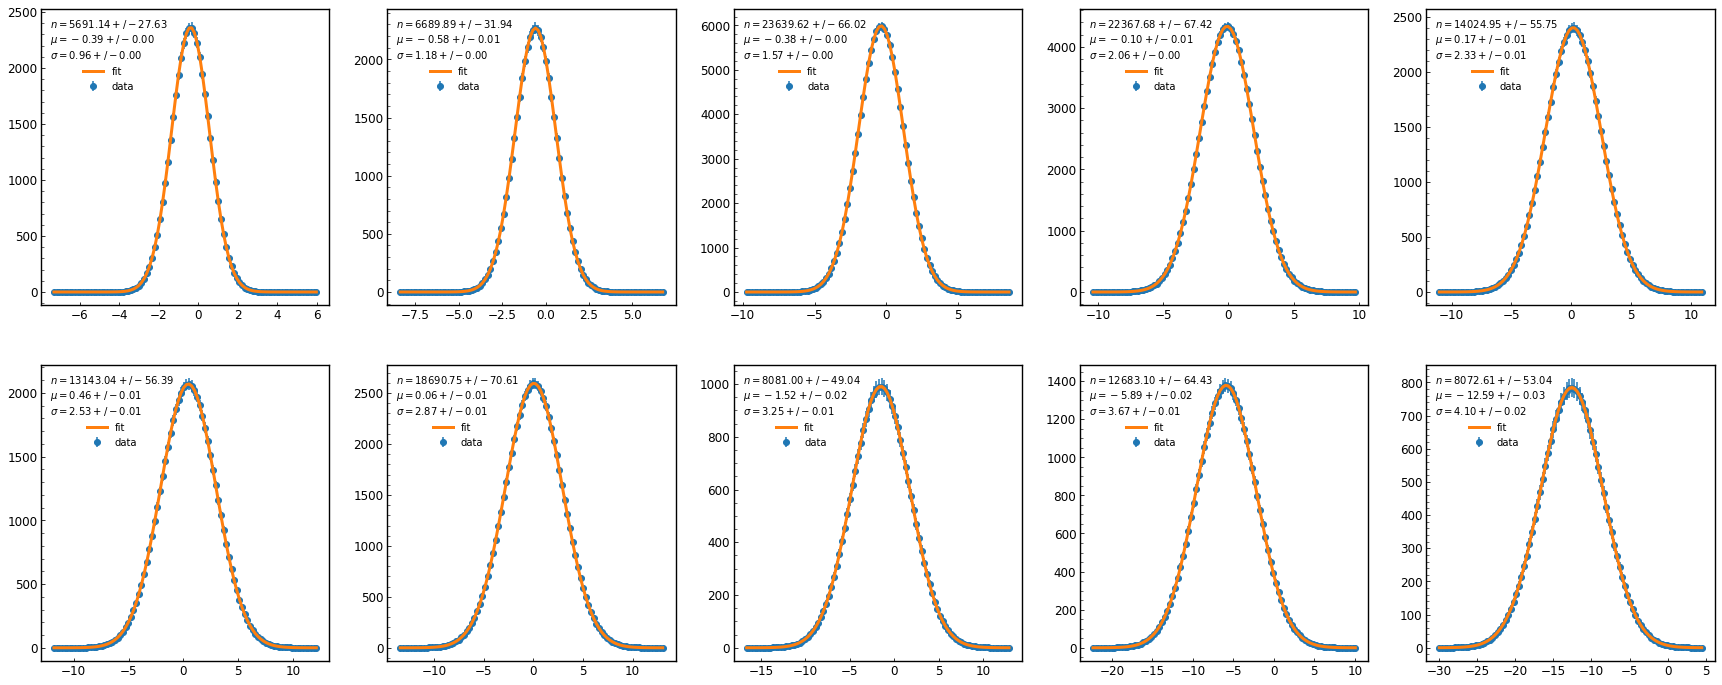

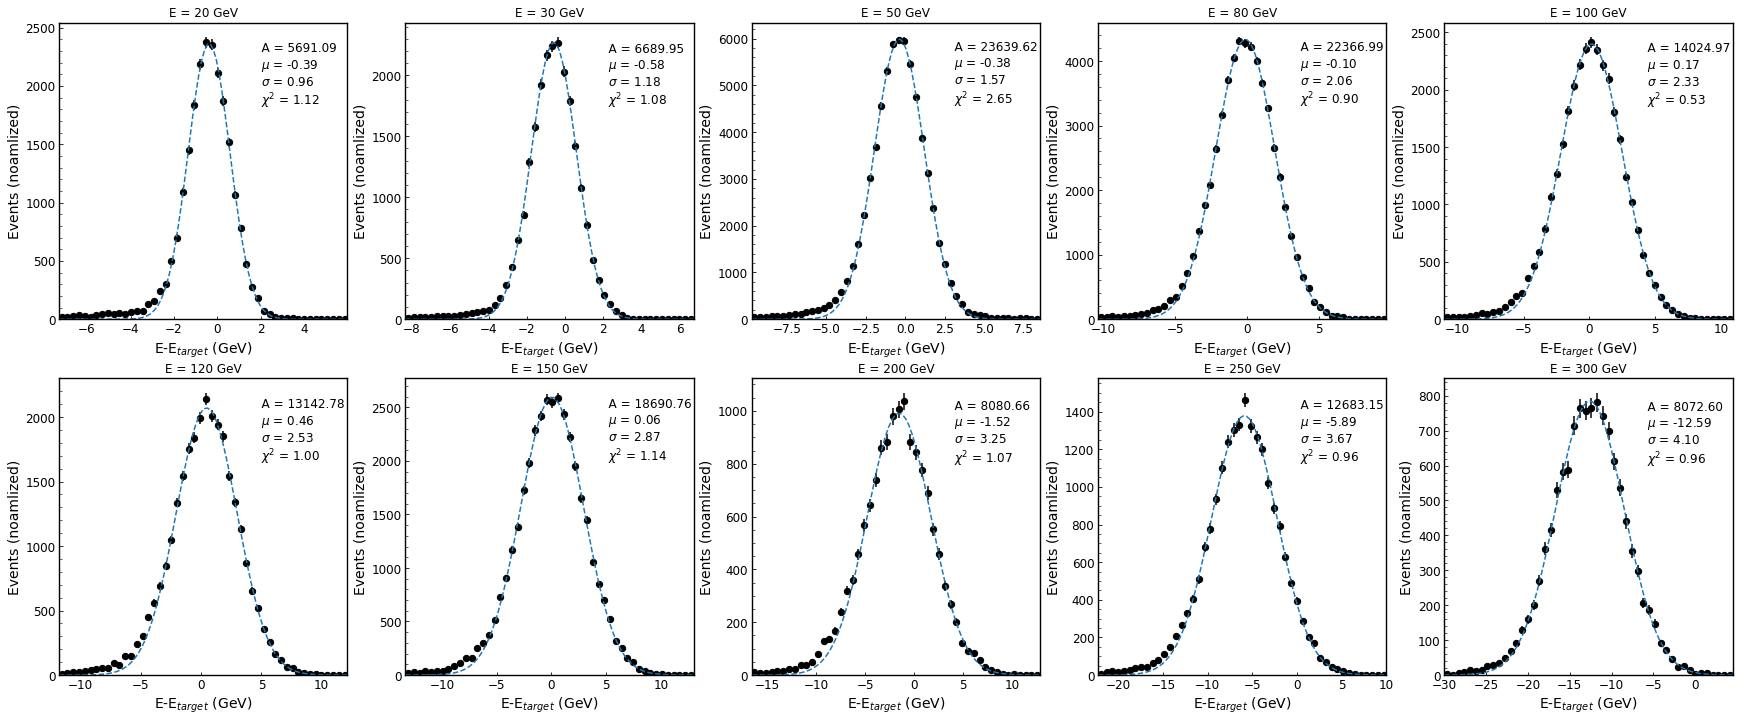

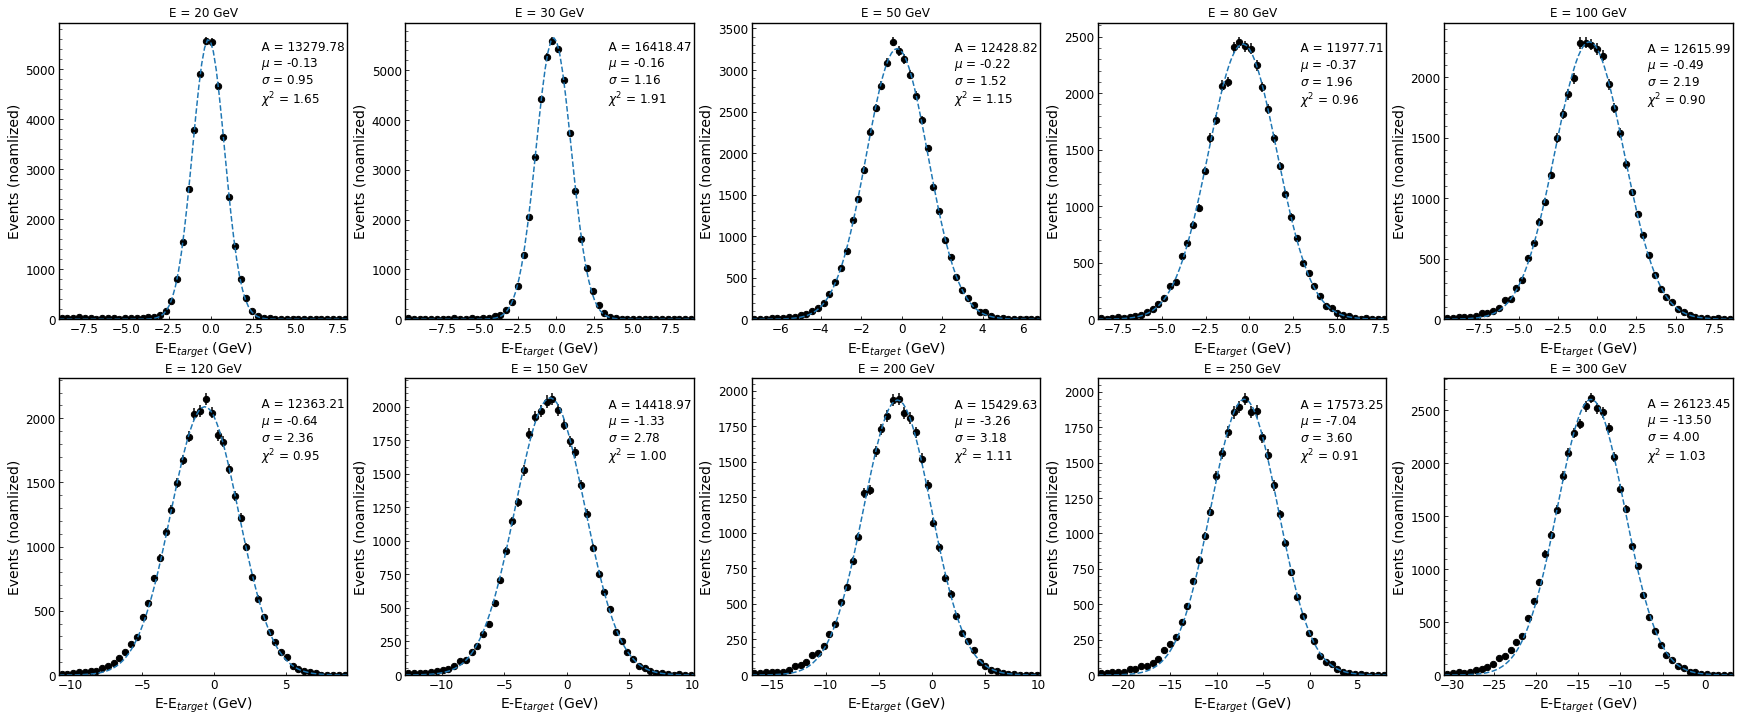

┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  13.28e3  │  0.05e3   │            │            │         │         │       │
│ 1 │ mu_    │  -0.1330  │  0.0034   │            │            │         │         │       │
│ 2 │ sigma_ │  0.9464   │  0.0024   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  16.42e3  │  0.06e3   │            │            │      

<Figure size 432x288 with 0 Axes>

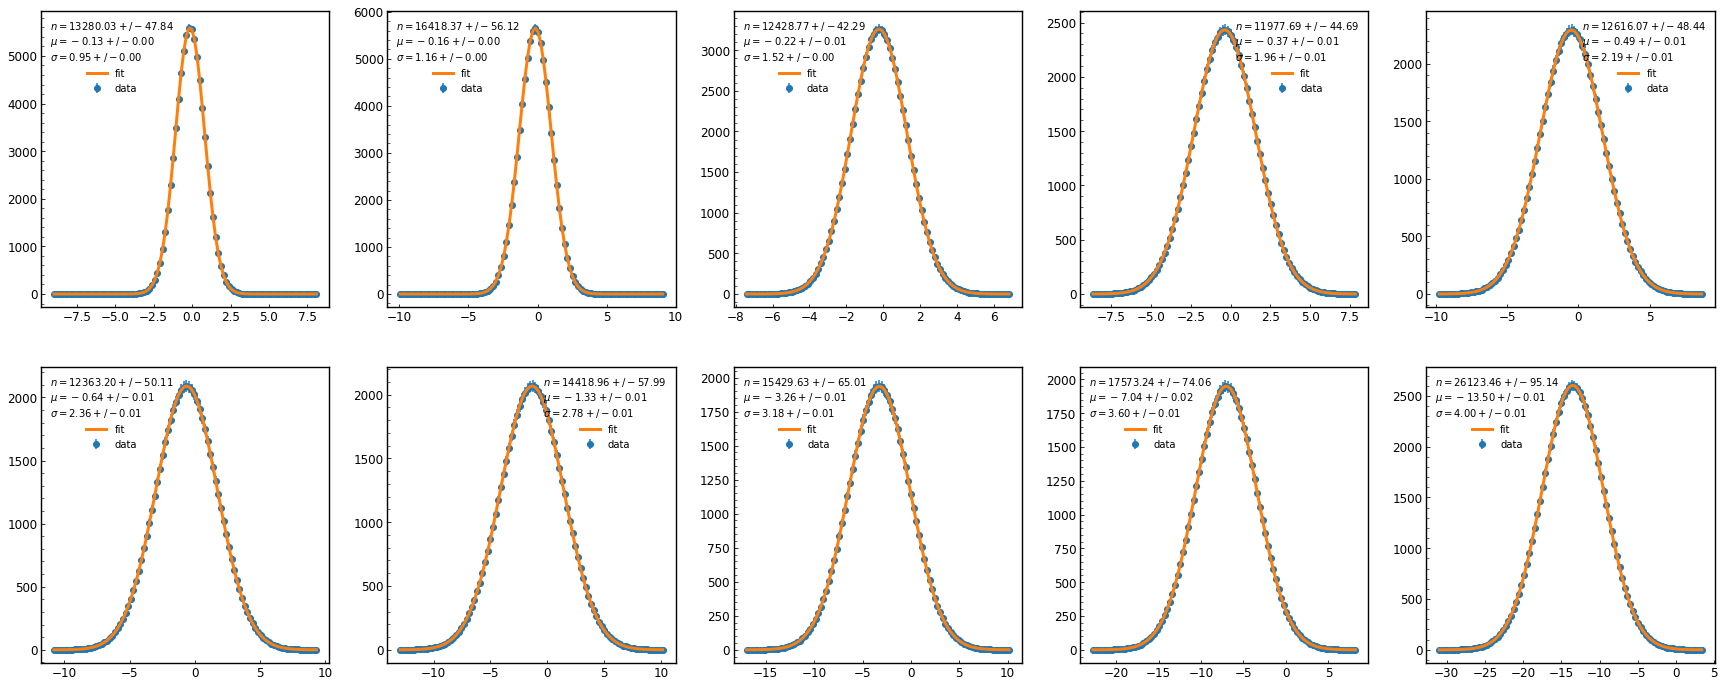

In [8]:
plt.clf()
fig, axarray = plt.subplots(2, 5)
fig.set_figheight(12)
fig.set_figwidth(30)

fit_params_mc = []
fit_params_data = []

with open('plots/pkl/rechit_energy_sum_data_scaled.pkl','rb') as f0:
    data_array = pickle.load(f0)
    
with open('plots/pkl/rechit_energy_sum_mc.pkl','rb') as f0:
    mc_array = pickle.load(f0)

for ie in range(data_array.size):
    irow = int(ie/5)
    jcol = int(ie%5)
    x = data_array[irow][jcol].lines[0].get_xdata()
    y = data_array[irow][jcol].lines[0].get_ydata()
    fit_params_data.append(fit_imu(axarray[irow, jcol], x, y))
plot_name = 'plots/img/imuinuit_fit_data.png'
plt.savefig(plot_name)
plt.show()

plt.clf()
fig, axarray = plt.subplots(2, 5)
fig.set_figheight(12)
fig.set_figwidth(30)

fit_params_mc = []

for ie in range(mc_array.size):
    irow = int(ie/5)
    jcol = int(ie%5)
    x = mc_array[irow][jcol].lines[0].get_xdata()
    y = mc_array[irow][jcol].lines[0].get_ydata()
    fit_params_mc.append(fit_imu(axarray[irow, jcol], x, y))
plot_name = 'plots/img/imuinuit_fit_mc.png'
plt.savefig(plot_name)
plt.show()

In [26]:
data_err = [ abs(_fit[3]/_fit[1])+0.0177 for _fit in fit_params_data[::-1]]
mc_err = [ abs(_fit[3]/_fit[1])+0.002 for _fit in fit_params_mc[::-1]]

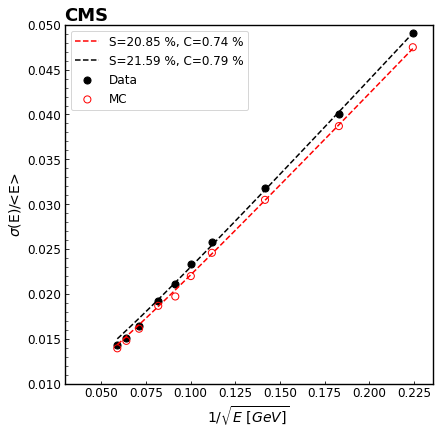

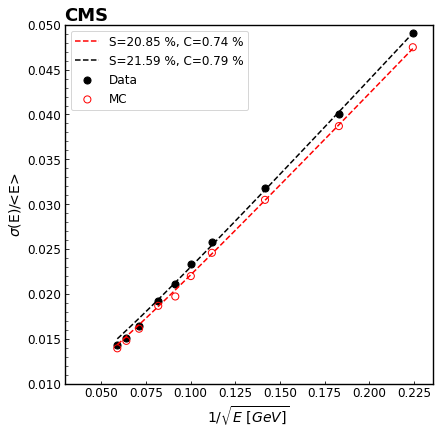

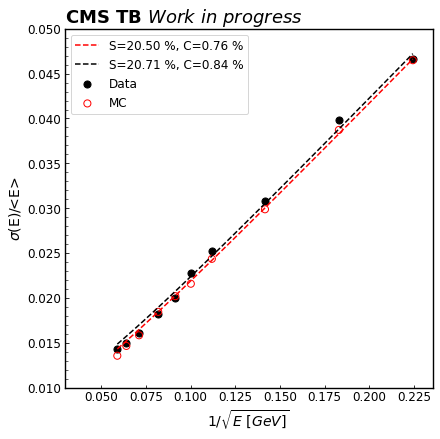

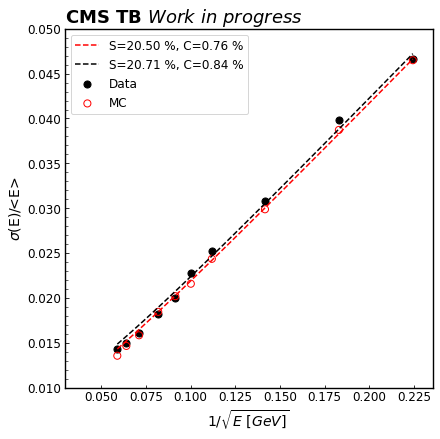

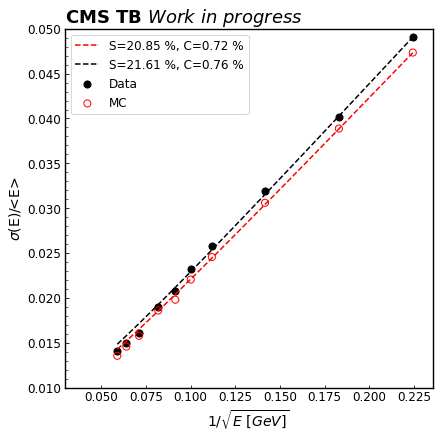

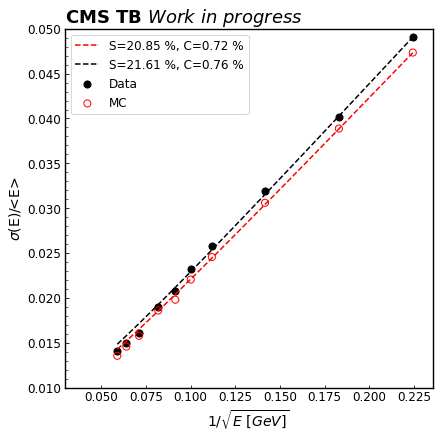

In [10]:
with open('plots/pkl/res_rechit_sum_data.pkl','rb') as f0:
    res_rechit_sum_data_array = pickle.load(f0)
with open('plots/pkl/res_rechit_sum_mc.pkl','rb') as f0:
    res_rechit_sum_mc_array = pickle.load(f0)
    
with open('plots/pkl/res_drn_data.pkl','rb') as f0:
    res_drn_data_array = pickle.load(f0)
with open('plots/pkl/res_drn_mc.pkl','rb') as f0:
    res_drn_mc_array = pickle.load(f0)

with open('plots/pkl/res_dnn_data.pkl','rb') as f0:
    res_dnn_data_array = pickle.load(f0)
with open('plots/pkl/res_dnn_mc.pkl','rb') as f0:
    res_dnn_mc_array = pickle.load(f0)

res_rechit_sum_data_x = res_rechit_sum_data_array.get_offsets().data[:,0]
res_rechit_sum_data_y = res_rechit_sum_data_array.get_offsets().data[:,1]

res_rechit_sum_mc_x = res_rechit_sum_mc_array.get_offsets().data[:,0]
res_rechit_sum_mc_y = res_rechit_sum_mc_array.get_offsets().data[:,1]

res_drn_data_x = res_drn_data_array.get_offsets().data[:,0]
res_drn_data_y = res_drn_data_array.get_offsets().data[:,1]

res_drn_mc_x = res_drn_mc_array.get_offsets().data[:,0]
res_drn_mc_y = res_drn_mc_array.get_offsets().data[:,1]

res_dnn_data_x = res_dnn_data_array.get_offsets().data[:,0]
res_dnn_data_y = res_dnn_data_array.get_offsets().data[:,1]

res_dnn_mc_x = res_dnn_mc_array.get_offsets().data[:,0]
res_dnn_mc_y = res_dnn_mc_array.get_offsets().data[:,1]

Data:  0.2181801361493629 0.006485956368901599
MC:  0.20972764828489313 0.006291720587764523


<Figure size 432x288 with 0 Axes>

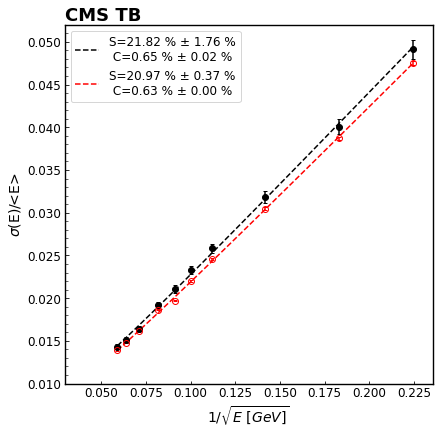

In [35]:
plt.clf()
plt.figure(figsize=(6.6,6.6))

x = res_rechit_sum_data_x
y = res_rechit_sum_data_y
least_squares = LeastSquares((x**2), (y**2), 2*np.array(data_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
print('Data: ', np.sqrt(m.values[0]), np.sqrt(m.values[1]))

xarray = np.linspace(res_rechit_sum_data_x[-1], res_rechit_sum_data_x[0], 64)
yarray_data_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])

plt.errorbar(res_rechit_sum_data_x, res_rechit_sum_data_y, yerr=data_err*res_rechit_sum_data_y,
         c='black', marker='o', linestyle='none', capsize=2)

plt.plot(xarray, yarray_data_sum,
         c='black', linestyle='--', 
         label='S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                            np.sqrt(m.values[1])*100, m.errors[1]*50))

x = res_rechit_sum_mc_x
y = res_rechit_sum_mc_y
least_squares = LeastSquares(x**2, y**2, 2*np.array(mc_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
print('MC: ',np.sqrt(m.values[0]), np.sqrt(m.values[1]))

plt.errorbar(res_rechit_sum_mc_x, res_rechit_sum_mc_y, yerr=mc_err*res_rechit_sum_mc_y,
         c='red', marker='o', linestyle='none', capsize=2, markerfacecolor='none')

yarray_mc_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])

plt.plot(xarray, yarray_mc_sum,
         c='red', linestyle='--', label='S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                                                    np.sqrt(m.values[1])*100, m.errors[1]*50))

cms = plt.text(x=res_rechit_sum_data_x[-1]*0.5, y=0.052, s="CMS TB",
    fontsize=18, fontweight='bold',
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')

slope_text= plt.text(x=0.0, y=0.035, s='')

plt.ylim(0.01, 0.052)
plt.xlim(res_rechit_sum_data_x[-1]*0.5, res_rechit_sum_data_x[0]*1.05)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()

┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  10.89e3  │  0.04e3   │            │            │         │         │       │
│ 1 │ mu_    │  -0.1465  │  0.0033   │            │            │         │         │       │
│ 2 │ sigma_ │  0.9201   │  0.0023   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  16.23e3  │  0.06e3   │            │            │      

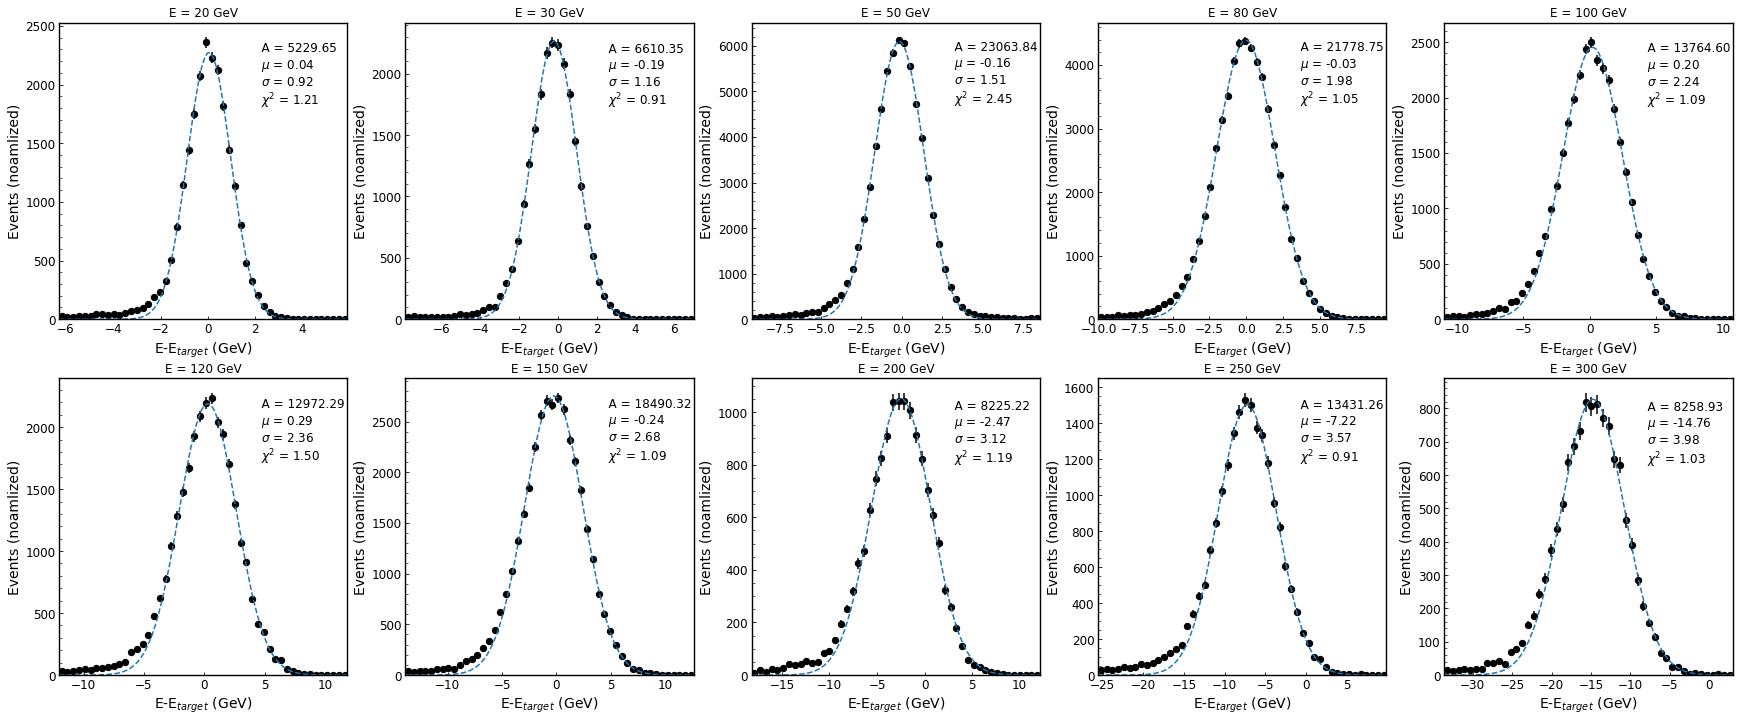

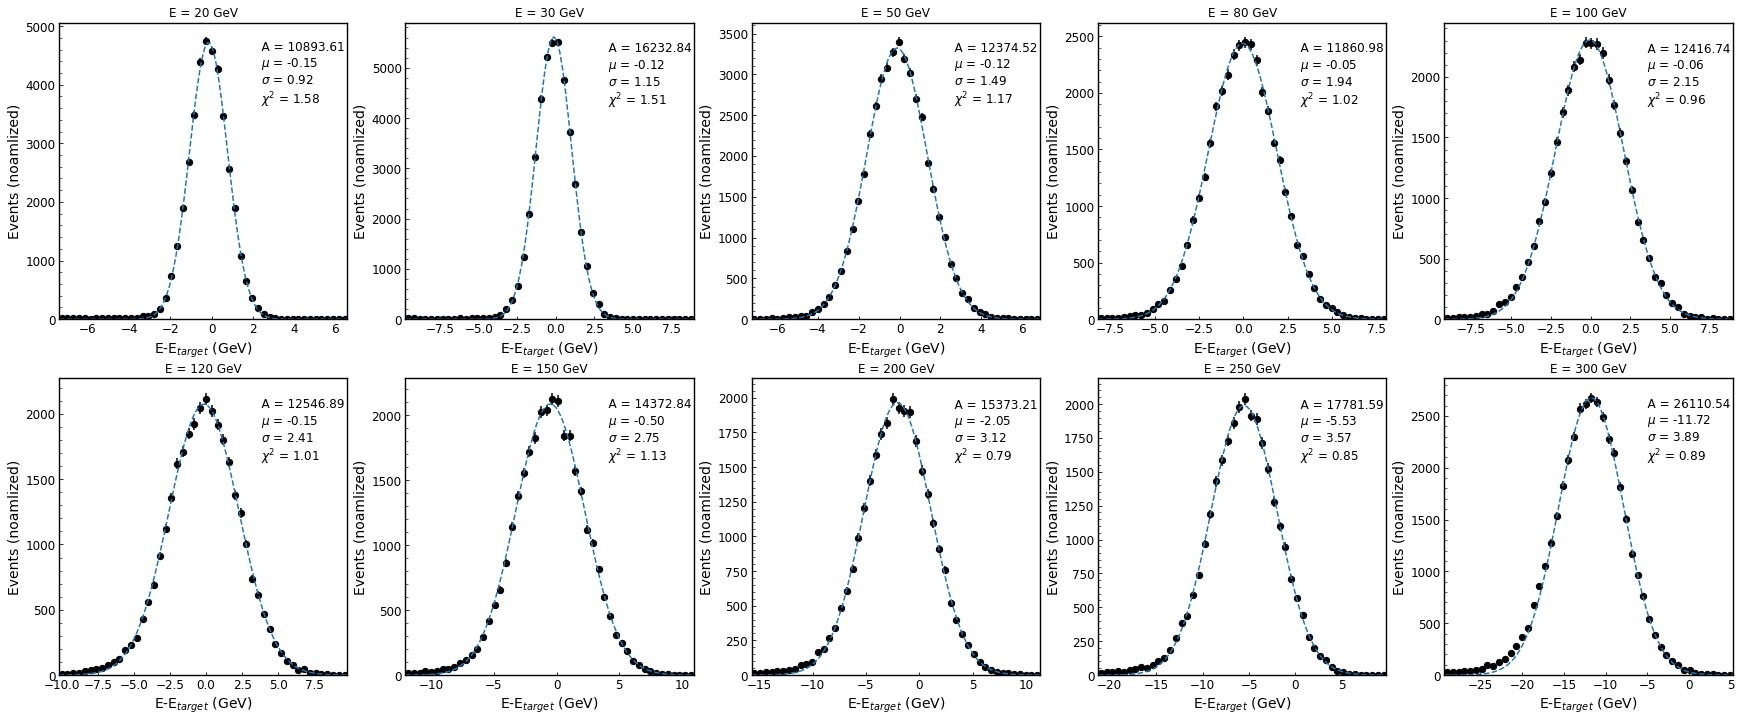

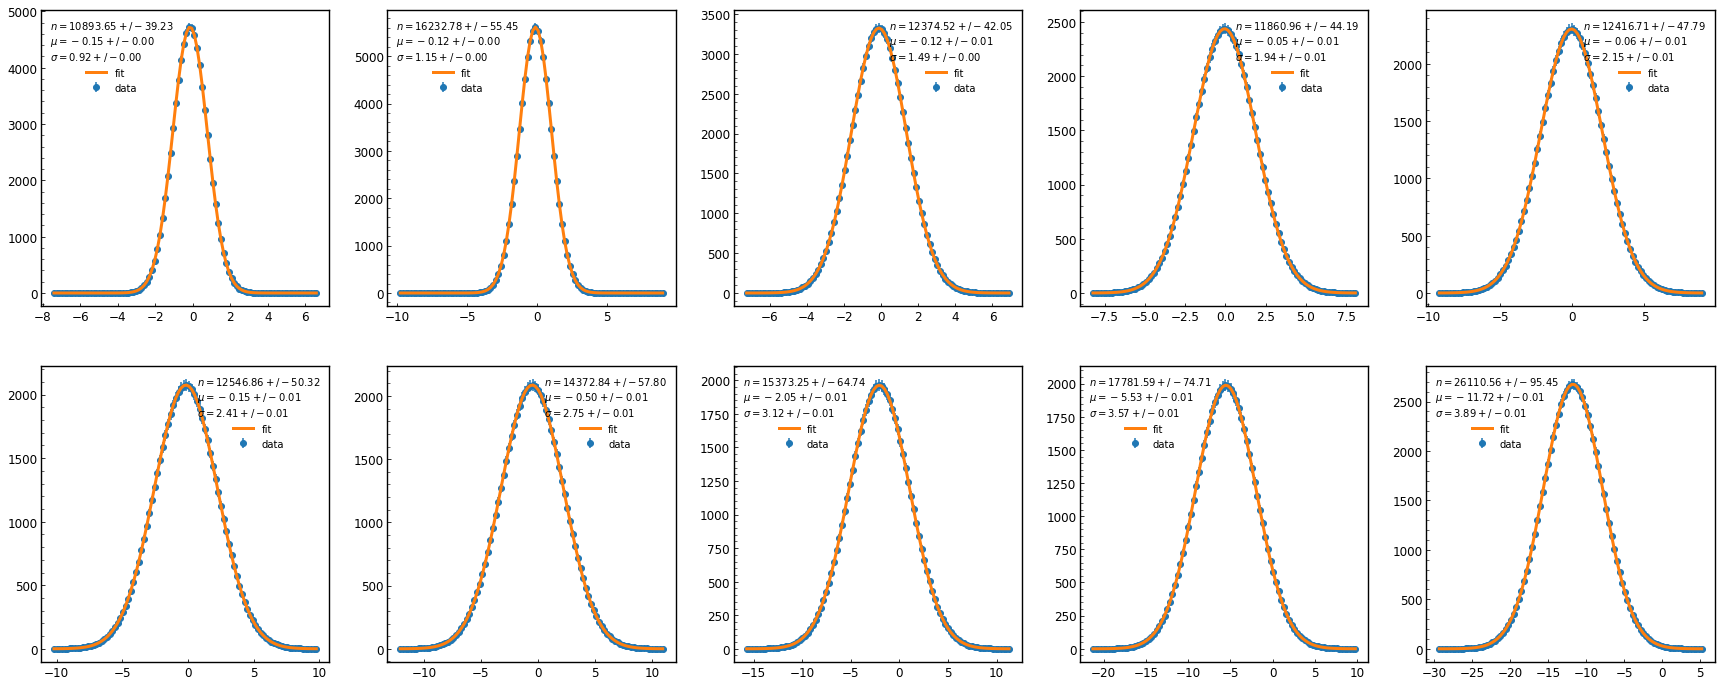

┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  5.230e3  │  0.025e3  │            │            │         │         │       │
│ 1 │ mu_    │   0.044   │   0.004   │            │            │         │         │       │
│ 2 │ sigma_ │  0.9170   │  0.0032   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  6.610e3  │  0.032e3  │            │            │      

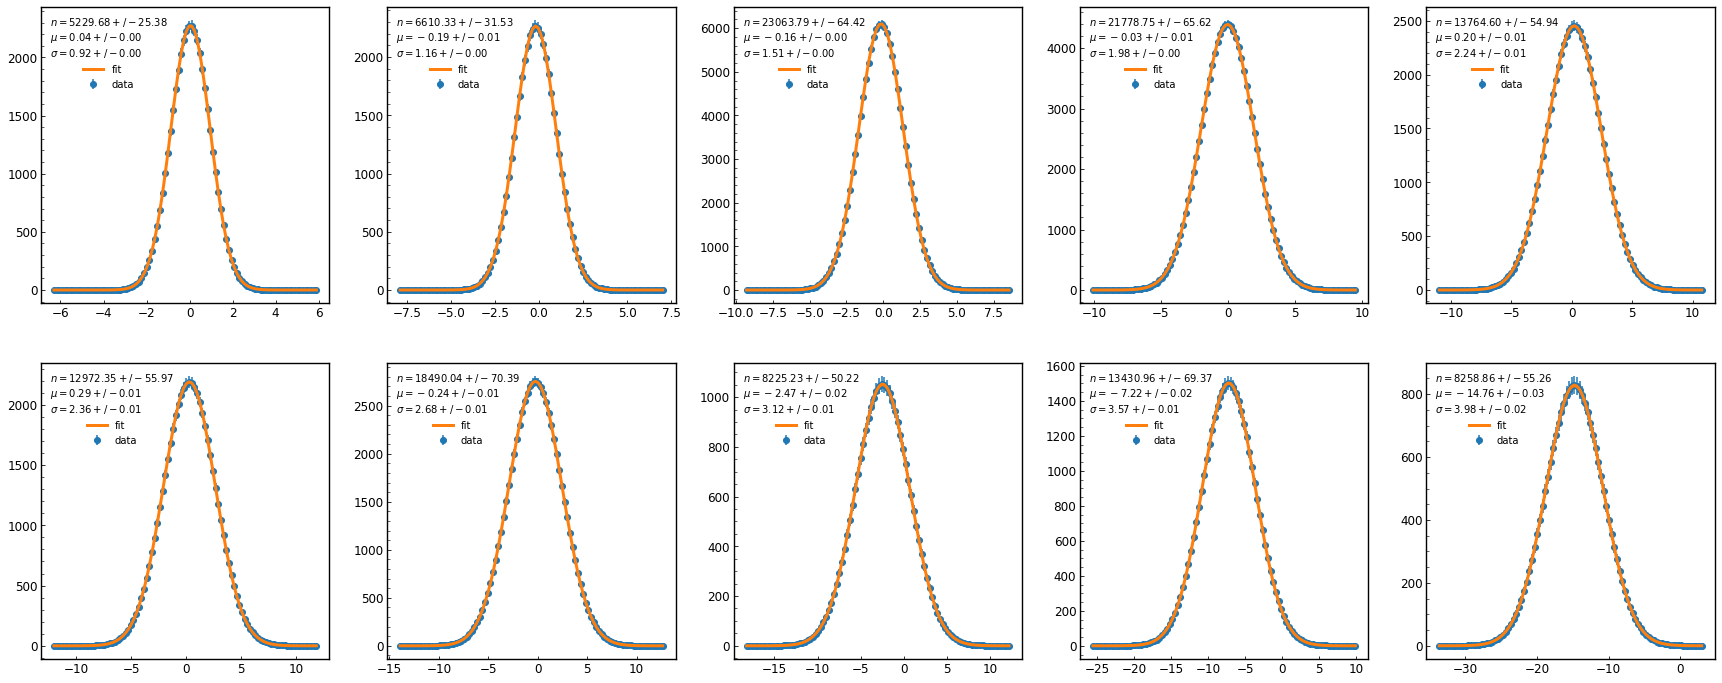

In [20]:
with open('plots/pkl/drn_data_scaled.pkl','rb') as f0:
    drn_data_array = pickle.load(f0)

with open('plots/pkl/drn_mc.pkl','rb') as f0:
    drn_mc_array = pickle.load(f0)

fit_params_drn_mc = []
fit_params_drn_data = []

fig, axarray = plt.subplots(2, 5)
fig.set_figheight(12)
fig.set_figwidth(30)

for ie in range(drn_mc_array.size):
    irow = int(ie/5)
    jcol = int(ie%5)
    x = drn_mc_array[irow][jcol].lines[0].get_xdata()
    y = drn_mc_array[irow][jcol].lines[0].get_ydata()
    fit_params_drn_mc.append(fit_imu(axarray[irow, jcol], x, y))
plot_name = 'plots/img/imuinuit_fit_drn_mc.png'
plt.savefig(plot_name)
plt.show()

fig, axarray = plt.subplots(2, 5)
fig.set_figheight(12)
fig.set_figwidth(30)

for ie in range(drn_data_array.size):
    irow = int(ie/5)
    jcol = int(ie%5)
    x = drn_data_array[irow][jcol].lines[0].get_xdata()
    y = drn_data_array[irow][jcol].lines[0].get_ydata()
    fit_params_drn_data.append(fit_imu(axarray[irow, jcol], x, y))
plot_name = 'plots/img/imuinuit_fit_drn_data.png'
plt.savefig(plot_name)
plt.show()

In [27]:
data_drn_err = [ abs(_fit[3]/_fit[1])+0.0144 for _fit in fit_params_drn_data[::-1]]
mc_drn_err = [ abs(_fit[3]/_fit[1])+0.004 for _fit in fit_params_drn_mc[::-1]]

Data:  0.2101672605324408 0.006936263468824116
MC:  0.20692662991367175 0.006364430465342639


<Figure size 432x288 with 0 Axes>

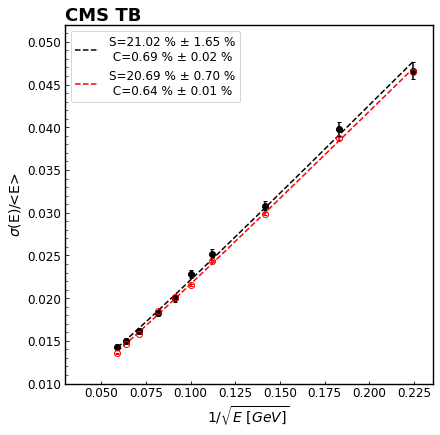

In [31]:
plt.clf()
plt.figure(figsize=(6.6,6.6))

x = res_drn_data_x
y = res_drn_data_y
least_squares = LeastSquares((x**2), (y**2), 2*np.array(data_drn_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
print('Data: ', np.sqrt(m.values[0]), np.sqrt(m.values[1]))

xarray = np.linspace(res_drn_data_x[-1], res_drn_data_x[0], 64)
yarray_data_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])

plt.errorbar(res_drn_data_x, res_drn_data_y, yerr=data_drn_err*res_drn_data_y,
         c='black', marker='o', linestyle='none', capsize=2)

plt.plot(xarray, yarray_data_sum,
         c='black', linestyle='--', 
         label='S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                            np.sqrt(m.values[1])*100, m.errors[1]*50))

x = res_drn_mc_x
y = res_drn_mc_y
least_squares = LeastSquares(x**2, y**2, 2*np.array(mc_drn_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
print('MC: ',np.sqrt(m.values[0]), np.sqrt(m.values[1]))

plt.errorbar(res_drn_mc_x, res_drn_mc_y, yerr=mc_err*res_drn_mc_y,
         c='red', marker='o', linestyle='none', capsize=2, markerfacecolor='none')

yarray_mc_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])

plt.plot(xarray, yarray_mc_sum,
         c='red', linestyle='--', label='S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                                                    np.sqrt(m.values[1])*100, m.errors[1]*50))

cms = plt.text(x=res_drn_data_x[-1]*0.5, y=0.052, s="CMS TB",
    fontsize=18, fontweight='bold',
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')

slope_text= plt.text(x=0.0, y=0.035, s='')

plt.ylim(0.01, 0.052)
plt.xlim(res_drn_data_x[-1]*0.5, res_drn_data_x[0]*1.05)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()

┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  11.18e3  │  0.04e3   │            │            │         │         │       │
│ 1 │ mu_    │  0.2115   │  0.0034   │            │            │         │         │       │
│ 2 │ sigma_ │  0.9485   │  0.0024   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  17.06e3  │  0.06e3   │            │            │      

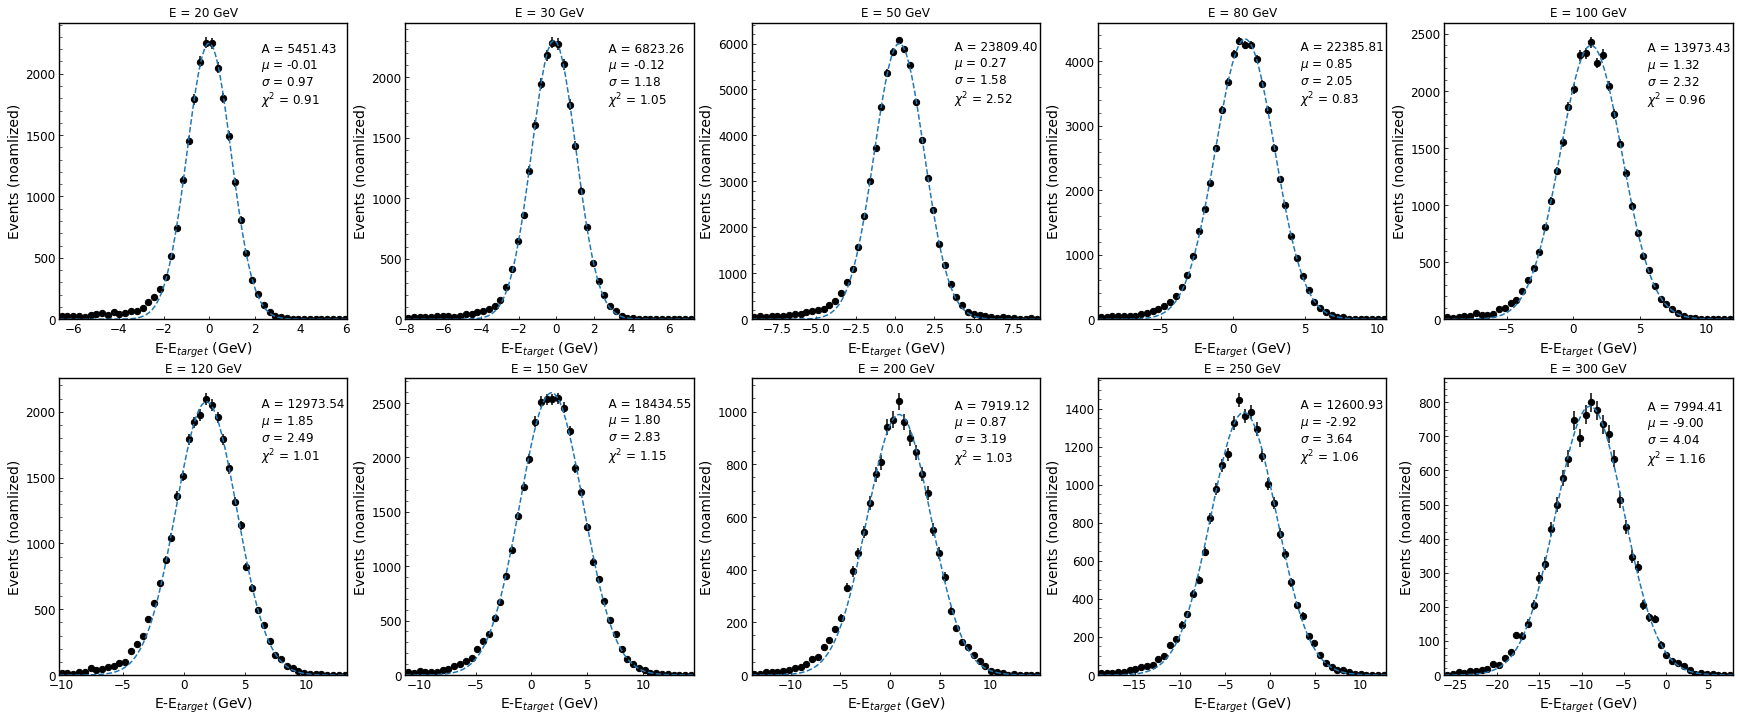

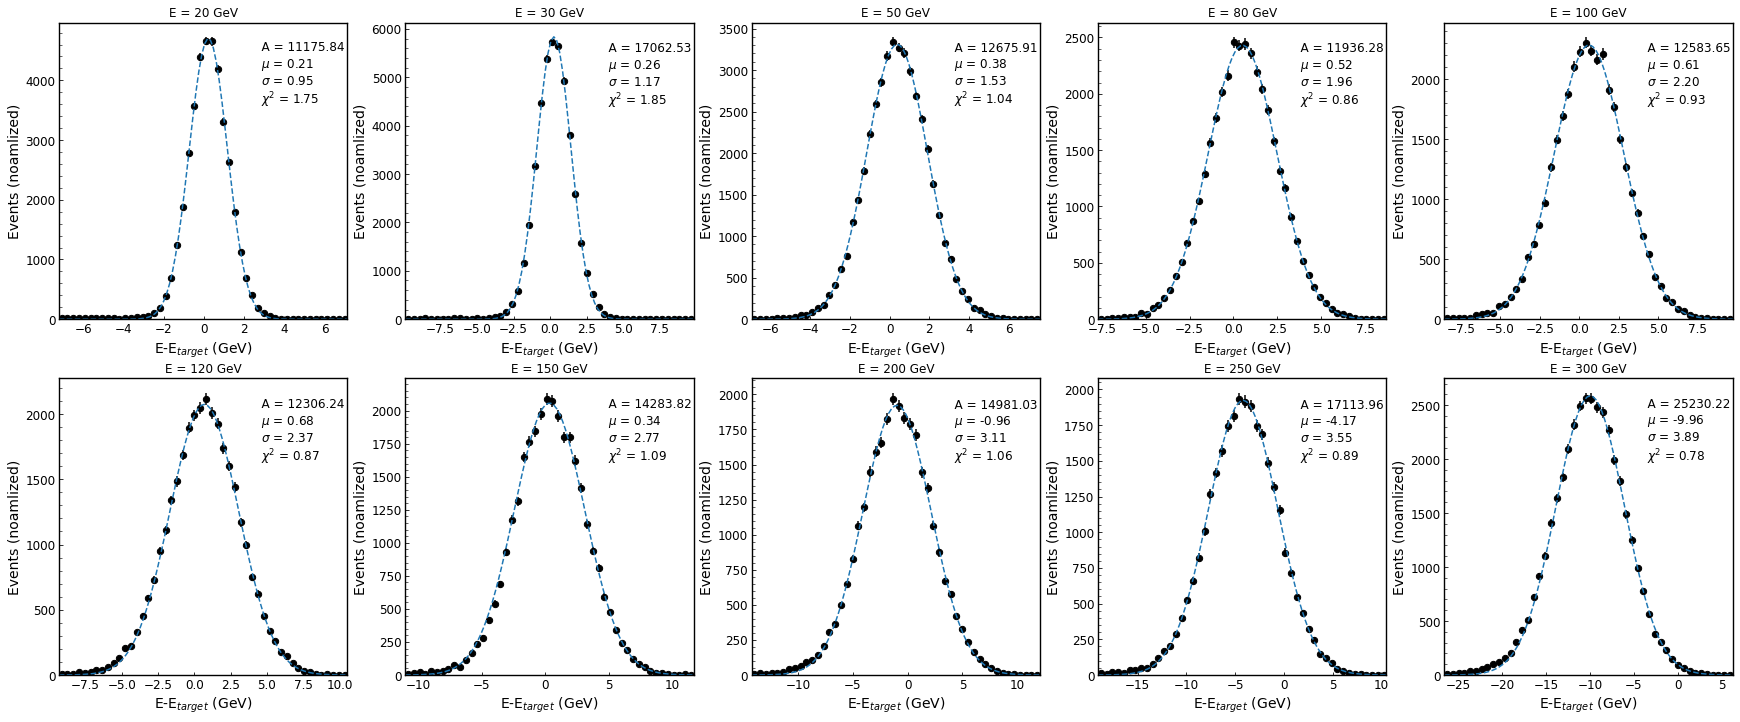

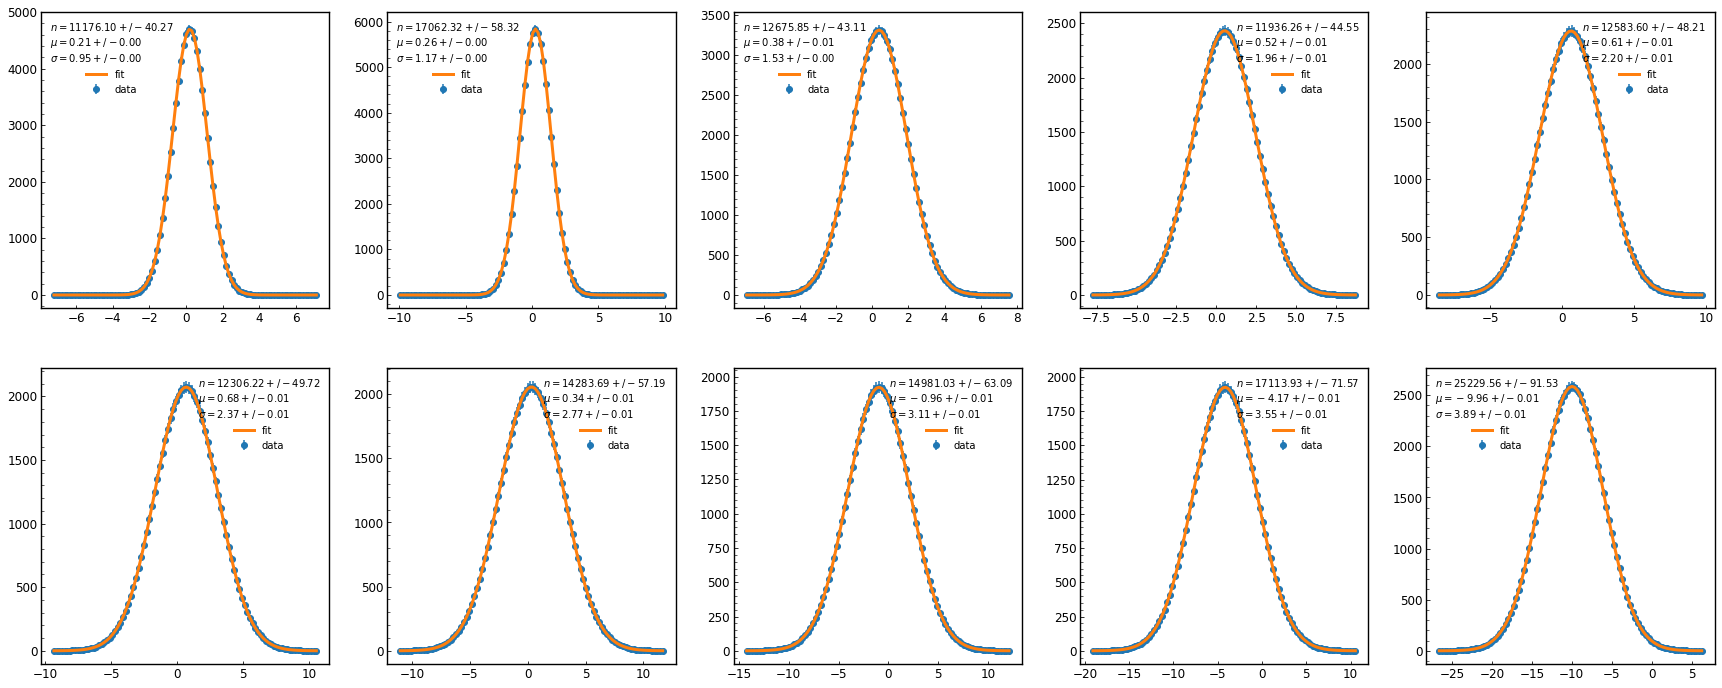

┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  5.451e3  │  0.027e3  │            │            │         │         │       │
│ 1 │ mu_    │  -0.015   │   0.005   │            │            │         │         │       │
│ 2 │ sigma_ │  0.9663   │  0.0033   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_  │  6.823e3  │  0.033e3  │            │            │      

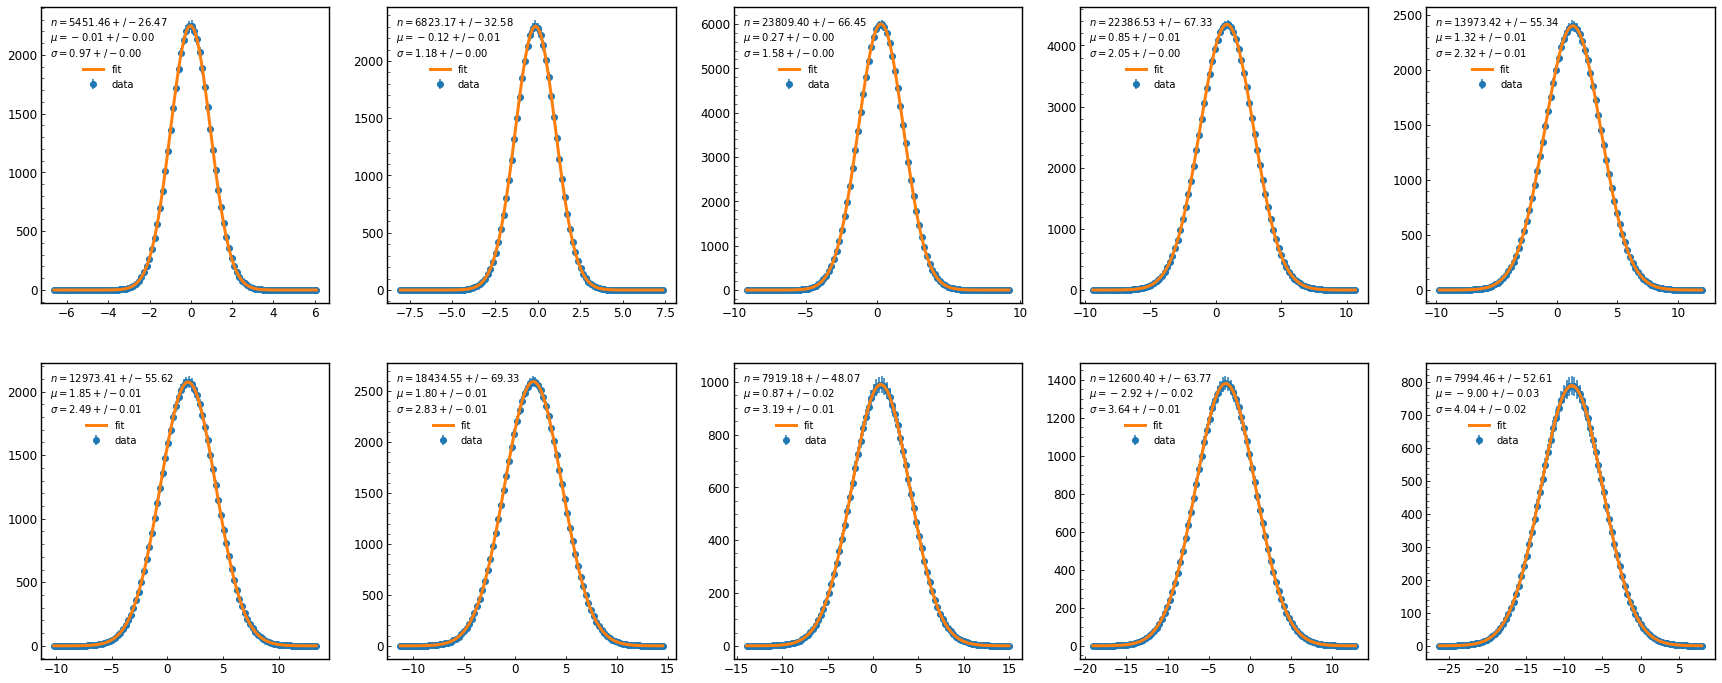

In [21]:
with open('plots/pkl/dnn_data_scaled.pkl','rb') as f0:
    dnn_data_array = pickle.load(f0)

with open('plots/pkl/dnn_mc.pkl','rb') as f0:
    dnn_mc_array = pickle.load(f0)
    
fit_params_dnn_mc = []
fit_params_dnn_data = []

fig, axarray = plt.subplots(2, 5)
fig.set_figheight(12)
fig.set_figwidth(30)

for ie in range(dnn_mc_array.size):
    irow = int(ie/5)
    jcol = int(ie%5)
    x = dnn_mc_array[irow][jcol].lines[0].get_xdata()
    y = dnn_mc_array[irow][jcol].lines[0].get_ydata()
    fit_params_dnn_mc.append(fit_imu(axarray[irow, jcol], x, y))
plot_name = 'plots/img/imuinuit_fit_dnn_mc.png'
plt.savefig(plot_name)
plt.show()

fig, axarray = plt.subplots(2, 5)
fig.set_figheight(12)
fig.set_figwidth(30)

for ie in range(dnn_data_array.size):
    irow = int(ie/5)
    jcol = int(ie%5)
    x = dnn_data_array[irow][jcol].lines[0].get_xdata()
    y = dnn_data_array[irow][jcol].lines[0].get_ydata()
    fit_params_dnn_data.append(fit_imu(axarray[irow, jcol], x, y))
plot_name = 'plots/img/imuinuit_fit_dnn_data.png'
plt.savefig(plot_name)
plt.show()

In [30]:
data_dnn_err = [ 2*abs(_fit[3]/_fit[1])+0.0144 for _fit in fit_params_dnn_data]
mc_dnn_err = [2*abs(_fit[3]/_fit[1])+0.004 for _fit in fit_params_dnn_mc]

Data:  0.21880485159310778 0.005949695430336204
MC:  0.21051472254799333 0.005718632243502882


<Figure size 432x288 with 0 Axes>

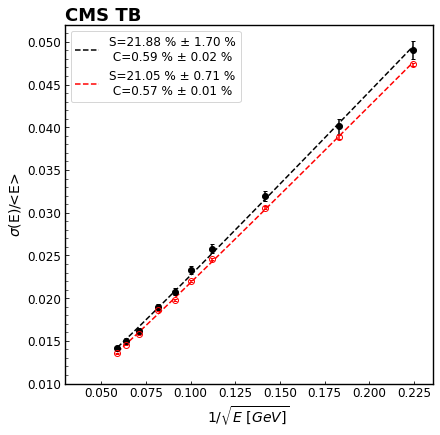

In [32]:
plt.clf()
plt.figure(figsize=(6.6,6.6))

x = res_dnn_data_x
y = res_dnn_data_y
least_squares = LeastSquares((x**2), (y**2), 2*np.array(data_dnn_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
print('Data: ', np.sqrt(m.values[0]), np.sqrt(m.values[1]))

xarray = np.linspace(res_dnn_data_x[-1], res_dnn_data_x[0], 64)
yarray_data_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])

plt.errorbar(res_dnn_data_x, res_dnn_data_y, yerr=data_dnn_err*res_dnn_data_y,
         c='black', marker='o', linestyle='none', capsize=2)

plt.plot(xarray, yarray_data_sum,
         c='black', linestyle='--', 
         label='S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                            np.sqrt(m.values[1])*100, m.errors[1]*50))

x = res_dnn_mc_x
y = res_dnn_mc_y
least_squares = LeastSquares(x**2, y**2, 2*np.array(mc_dnn_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
print('MC: ',np.sqrt(m.values[0]), np.sqrt(m.values[1]))

plt.errorbar(res_dnn_mc_x, res_dnn_mc_y, yerr=mc_err*res_dnn_mc_y,
         c='red', marker='o', linestyle='none', capsize=2, markerfacecolor='none')

yarray_mc_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])

plt.plot(xarray, yarray_mc_sum,
         c='red', linestyle='--', label='S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                                                    np.sqrt(m.values[1])*100, m.errors[1]*50))

cms = plt.text(x=res_dnn_data_x[-1]*0.5, y=0.052, s="CMS TB",
    fontsize=18, fontweight='bold',
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')

slope_text= plt.text(x=0.0, y=0.035, s='')

plt.ylim(0.01, 0.052)
plt.xlim(res_dnn_data_x[-1]*0.5, res_dnn_data_x[0]*1.05)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()

<Figure size 432x288 with 0 Axes>

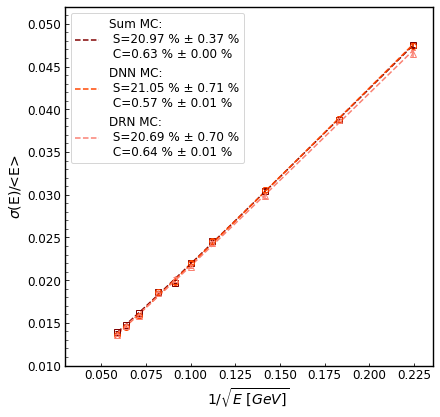

In [33]:
plt.clf()
plt.figure(figsize=(6.6,6.6))

x = res_rechit_sum_mc_x
y = res_rechit_sum_mc_y
least_squares = LeastSquares(x**2, y**2, 2*np.array(mc_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
plt.errorbar(res_rechit_sum_mc_x, res_rechit_sum_mc_y, yerr=mc_err*res_rechit_sum_mc_y,
         c='maroon', marker='s', linestyle='none', capsize=2, markerfacecolor='none')
yarray_mc_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])
plt.plot(xarray, yarray_mc_sum,
         c='maroon', linestyle='--', label='Sum MC:\n S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                                                    np.sqrt(m.values[1])*100, m.errors[1]*50))

x = res_dnn_mc_x
y = res_dnn_mc_y
least_squares = LeastSquares(x**2, y**2, 2*np.array(mc_dnn_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
plt.errorbar(res_dnn_mc_x, res_dnn_mc_y, yerr=mc_dnn_err*res_dnn_mc_y,
         c='orangered', marker='o', linestyle='none', capsize=2, markerfacecolor='none')

yarray_mc_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])
plt.plot(xarray, yarray_mc_sum,
         c='orangered', linestyle='--', label='DNN MC:\n S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                                                    np.sqrt(m.values[1])*100, m.errors[1]*50))

x = res_drn_mc_x
y = res_drn_mc_y
least_squares = LeastSquares(x**2, y**2, 2*np.array(mc_drn_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
plt.errorbar(res_drn_mc_x, res_drn_mc_y, yerr=mc_drn_err*res_drn_mc_y,
         c='salmon', marker='^', linestyle='none', capsize=2, markerfacecolor='none')

yarray_mc_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])
plt.plot(xarray, yarray_mc_sum,
         c='salmon', linestyle='--', label='DRN MC:\n S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                                                    np.sqrt(m.values[1])*100, m.errors[1]*50))

plt.ylim(0.01, 0.052)
plt.xlim(res_dnn_data_x[-1]*0.5, res_dnn_data_x[0]*1.05)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()
plt.show()

<Figure size 432x288 with 0 Axes>

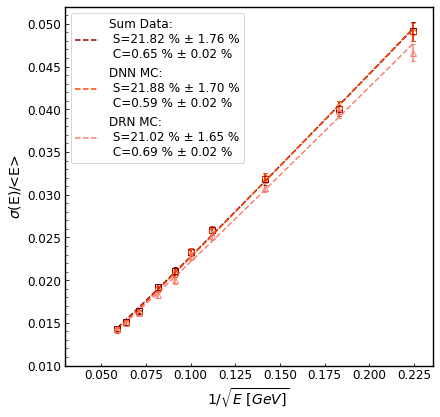

In [34]:
plt.clf()
plt.figure(figsize=(6.6,6.6))

x = res_rechit_sum_data_x
y = res_rechit_sum_data_y
least_squares = LeastSquares(x**2, y**2, 2*np.array(data_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
plt.errorbar(res_rechit_sum_data_x, res_rechit_sum_data_y, yerr=data_err*res_rechit_sum_data_y,
         c='maroon', marker='s', linestyle='none', capsize=2, markerfacecolor='none')
yarray_data_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])
plt.plot(xarray, yarray_data_sum,
         c='maroon', linestyle='--', label='Sum Data:\n S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                                                    np.sqrt(m.values[1])*100, m.errors[1]*50))

x = res_dnn_data_x
y = res_dnn_data_y
least_squares = LeastSquares(x**2, y**2, 2*np.array(data_dnn_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
plt.errorbar(res_dnn_data_x, res_dnn_data_y, yerr=data_dnn_err*res_dnn_data_y,
         c='orangered', marker='o', linestyle='none', capsize=2, markerfacecolor='none')

yarray_data_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])
plt.plot(xarray, yarray_data_sum,
         c='orangered', linestyle='--', label='DNN MC:\n S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                                                    np.sqrt(m.values[1])*100, m.errors[1]*50))

x = res_drn_data_x
y = res_drn_data_y
least_squares = LeastSquares(x**2, y**2, 2*np.array(data_drn_err)*y, line)
m = Minuit(least_squares, a=0.2, b=0.0074)  # starting values for m and c
m.migrad()
plt.errorbar(res_drn_data_x, res_drn_data_y, yerr=data_drn_err*res_drn_data_y,
         c='salmon', marker='^', linestyle='none', capsize=2, markerfacecolor='none')

yarray_data_sum =  np.sqrt(m.values[0]*(xarray**2)+m.values[1])
plt.plot(xarray, yarray_data_sum,
         c='salmon', linestyle='--', label='DRN MC:\n S={:0.2f} % ± {:0.2f} %\n C={:0.2f} % ± {:0.2f} %'.format(np.sqrt(m.values[0])*100, m.errors[0]*50,
                                                                                                    np.sqrt(m.values[1])*100, m.errors[1]*50))

plt.ylim(0.01, 0.052)
plt.xlim(res_dnn_data_x[-1]*0.5, res_dnn_data_x[0]*1.05)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()
plt.show()

In [ ]:
#check the flat sample

mc_flat = 